<h2><center>American Sign Language Detection</center></h2>

# Importing packages

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np

# Importing the dataset from training directory

We used a generic data loader called $\texttt{ImageFolder}$. It works well when the images are arranged similarly to our data-set.

In [2]:
DATA_ROOT_FOLDER = '/home/kamiar/proj/asl_alphabet_train/asl_alphabet_train'
data_set = datasets.ImageFolder(DATA_ROOT_FOLDER, transform=transforms.ToTensor())

# Data processing

The data-set is divided into three parts: training, testing, and validation, with ratios of $80\%$, $10\%$, and $10\%$, respectively.

In [3]:
train_test_val_split = [0.8, 0.1, 0.1]

# generator=torch.Generator().manual_seed(42), is used to 
# make it possible to do the experiment again
train_set, test_set, val_set = torch.utils.data.random_split(data_set,
                                    [round(p * len(data_set)) for p in train_test_val_split],
                                    generator=torch.Generator().manual_seed(42))

print(f'Data-set\'s size: {len(data_set)}, ',
      f'Training\'s size: {len(train_set)}, '
      f'Testing\'s size:{len(test_set)}, ',
      f'Validation\'s size:{len(val_set)}.' )

Data-set's size: 87000,  Training's size: 69600, Testing's size:8700,  Validation's size:8700.


In [4]:
batch_size = 64
print(f'Batch size: {batch_size}')

train_loader    = torch.utils.data.DataLoader(train_set,    batch_size=batch_size, shuffle=True )
test_loader     = torch.utils.data.DataLoader(test_set,     batch_size=batch_size, shuffle=False)
val_loader      = torch.utils.data.DataLoader(val_set,      batch_size=batch_size, shuffle=False)

Batch size: 64


## Garbage Collection

Delete unused memory to improve performance.

In [5]:
%%capture 

import gc
del data_set
del train_set
del test_set
del val_set
gc.collect()

# Modeling

Here we used a simple CNN.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(kernel_size=(5, 5),out_channels=32,in_channels=3 )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(kernel_size=(3, 3),out_channels=64,in_channels=32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(147456 , 128)
        self.fc2 = nn.Linear(128, 29)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()

## Choosing the device

According to our tests, using a GPU instead of a CPU improves performance by up to $5$ times.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print('The hardware used here is: [' , device.type ,'], with index number: [', device.index,'].')

The hardware used here is: [ cuda ], with index number: [ 0 ].


## Model summery

In [8]:
from torchsummary import  summary
summary(model=model, input_size=(3, 200, 200), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 196, 196]           2,432
         MaxPool2d-2           [64, 32, 98, 98]               0
            Conv2d-3           [64, 64, 96, 96]          18,496
         MaxPool2d-4           [64, 64, 48, 48]               0
            Linear-5                  [64, 128]      18,874,496
            Linear-6                   [64, 29]           3,741
Total params: 18,899,165
Trainable params: 18,899,165
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 29.30
Forward/backward pass size (MB): 1110.39
Params size (MB): 72.09
Estimated Total Size (MB): 1211.78
----------------------------------------------------------------


## Selecting the loss function

In [9]:
loss_func = nn.CrossEntropyLoss()

## Selecting the optimizer algorithm

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

## Selecting the learning-rate scheduler

In [11]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

# Training

## Definig feed-forward function

The function that follows accepts a data loader and returns the total loss and total correctly predicted labels.

In [12]:
def forward(set_loader):
    set_loss = 0.0
    set_acc = 0.0
    model.eval()
    for i, data in enumerate(set_loader, 0):
        with torch.no_grad():

            inputs, labels = data        
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_func(outputs, labels)
                
            set_loss += loss.data
            set_acc += torch.sum(torch.eq(torch.argmax(outputs, dim=1), labels).long())
            
    return set_loss, set_acc

## Training and error tracking

In [13]:
num_epochs = 5
print(f'Number of epochs: {num_epochs}')

Number of epochs: 5


In [14]:
# These two lists will be plotted later to show how the loss and accuracy evolve.
train_loss_list_plot = []
train_acc_list_plot  = []

# total number of iterations
total_iter_count = 0
total_iter_count_list = []

for epoch in range(num_epochs):  

    train_loss = 0.0
    train_acc  = 0.0
    train_loss_plot = 0.0
    train_acc_plot  = 0.0
    
    model.train()
    for i, data in enumerate(train_loader, 0):
        total_iter_count += 1
        
        # Obtain the inputs; data consists of a list of [inputs, labels].
        inputs, labels = data
        
        # We only need these two lines if 
        # we're using a GPU. Otherwise, they are redundant.
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        # Tracking performance for printing every I iteration
        train_loss += loss.data
        train_acc  += torch.sum(torch.eq(torch.argmax(outputs, dim=1), labels).long())
        I = 250
        if i and not (i % I):
            print(f'Epoch: {epoch+1:02d}, Iteration: {i:4d}, ' +
                  f'Loss: {train_loss / I  / len(labels): .4f}, ' +
                  f'Accuracy: {100 * train_acc  / I / len(labels):6.3f}%, ' +
                  f'LR: {optimizer.param_groups[0]["lr"]:.4f}')
            train_loss = 0.0
            train_acc  = 0.0
        
        # Tracking performance for plotting every II iteration
        train_loss_plot += loss.data
        train_acc_plot  += torch.sum(torch.eq(torch.argmax(outputs, dim=1), labels).long())
        II = 50
        if i and not (i % II):
            total_iter_count_list.append(total_iter_count)
            train_loss_list_plot.append(train_loss_plot/II/ len(labels))
            train_acc_list_plot.append(100 * train_acc_plot/II/ len(labels))
            train_loss_plot = 0.0
            train_acc_plot  = 0.0
            
##### AFTER A FULL EPOCH##############################################
    # printing the error on the entire training data-set
    train_loss, train_acc = forward(train_loader)
    print('\n'+'***+++ Whole  TRAINING  DATA-SET +++***' + '\n' + f'Epoch: {epoch+1:02d}, ' +
        f'TRAIN_Loss: {train_loss / len(train_loader.dataset):1.4f}, ' +
        f'TRAIN_Accuracy: {100 * train_acc  / len(train_loader.dataset):6.3f}%' )   
    
    # printing the error on the entire validation data-set
    val_loss, val_acc = forward(val_loader)
    print('\n'+'***+++ Whole VALIDATION DATA-SET +++***' + '\n' + f'Epoch: {epoch+1:02d}, ' +
        f'VAL_Loss: {val_loss / len(val_loader.dataset): .4f}, ' +
        f'VAL_Accuracy: {100 * val_acc  / len(val_loader.dataset):6.3f}%' + '\n')   
    
    # reducing the learning rate
    scheduler.step()
    
# END OF TRAINING
print('Finished Training')

Epoch: 01, Iteration:  250, Loss:  0.0442, Accuracy: 16.269%, LR: 0.0500
Epoch: 01, Iteration:  500, Loss:  0.0256, Accuracy: 45.219%, LR: 0.0500
Epoch: 01, Iteration:  750, Loss:  0.0169, Accuracy: 62.431%, LR: 0.0500
Epoch: 01, Iteration: 1000, Loss:  0.0131, Accuracy: 71.381%, LR: 0.0500

***+++ Whole  TRAINING  DATA-SET +++***
Epoch: 01, TRAIN_Loss: 0.0129, TRAIN_Accuracy: 71.251%

***+++ Whole VALIDATION DATA-SET +++***
Epoch: 01, VAL_Loss:  0.0144, VAL_Accuracy: 68.368%

Epoch: 02, Iteration:  250, Loss:  0.0085, Accuracy: 81.219%, LR: 0.0350
Epoch: 02, Iteration:  500, Loss:  0.0070, Accuracy: 83.963%, LR: 0.0350
Epoch: 02, Iteration:  750, Loss:  0.0061, Accuracy: 85.750%, LR: 0.0350
Epoch: 02, Iteration: 1000, Loss:  0.0055, Accuracy: 87.606%, LR: 0.0350

***+++ Whole  TRAINING  DATA-SET +++***
Epoch: 02, TRAIN_Loss: 0.0063, TRAIN_Accuracy: 85.866%

***+++ Whole VALIDATION DATA-SET +++***
Epoch: 02, VAL_Loss:  0.0083, VAL_Accuracy: 82.149%

Epoch: 03, Iteration:  250, Loss:  0

## Loss and accuracy evolution throughout iterations

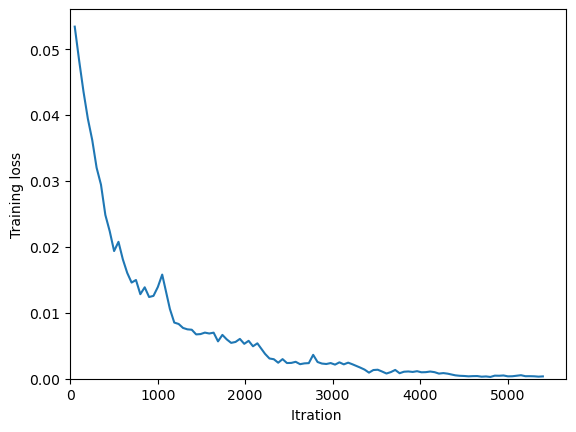

In [15]:
# transferring the loss list from the GPU to the CPU
train_loss_list_plot_cpu = torch.tensor(train_loss_list_plot, device = 'cpu')

plt.plot(total_iter_count_list, train_loss_list_plot_cpu)
plt.ylabel('Training loss')
plt.xlabel('Itration ')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()

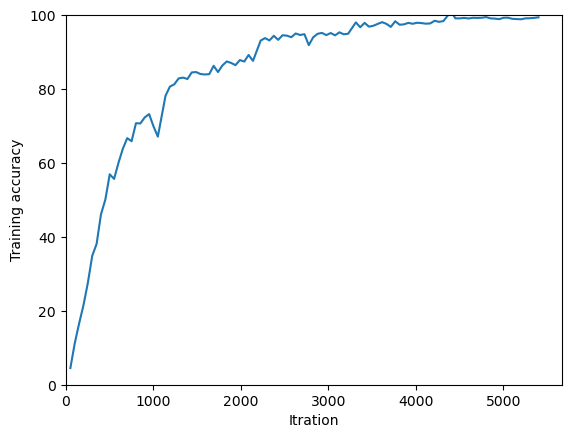

In [16]:
# transferring the accuracy list from the GPU to the CPU
train_acc_list_plot_cpu = torch.tensor(train_acc_list_plot, device = 'cpu')

plt.plot(total_iter_count_list, train_acc_list_plot_cpu)
plt.ylabel('Training accuracy')
plt.xlabel('Itration')
plt.ylim(bottom=0, top=100)
plt.xlim(left=0)
plt.show()

# Test final model

In [17]:
# we have 29 classes in this data-set
classes = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O',
         'P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space')

## Calculating the confusion matrix

In [18]:
confusion_matrix = np.zeros((29, 29))
class_count = np.zeros((29))

for i, data in enumerate(test_loader, 0):
    with torch.no_grad():

        inputs, labels = data        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = torch.max(outputs, dim=1)[1]
        
        for t, p in zip(labels, preds):
            confusion_matrix[t, p] += 1
            class_count[t.long()] += 1
        correct = sum([confusion_matrix[i,i] for i in range(29)])
print(f'Overall accuracy: {100*correct/sum(class_count):.2f}%')

Overall accuracy: 97.56%


## Confusion matrix heatmap

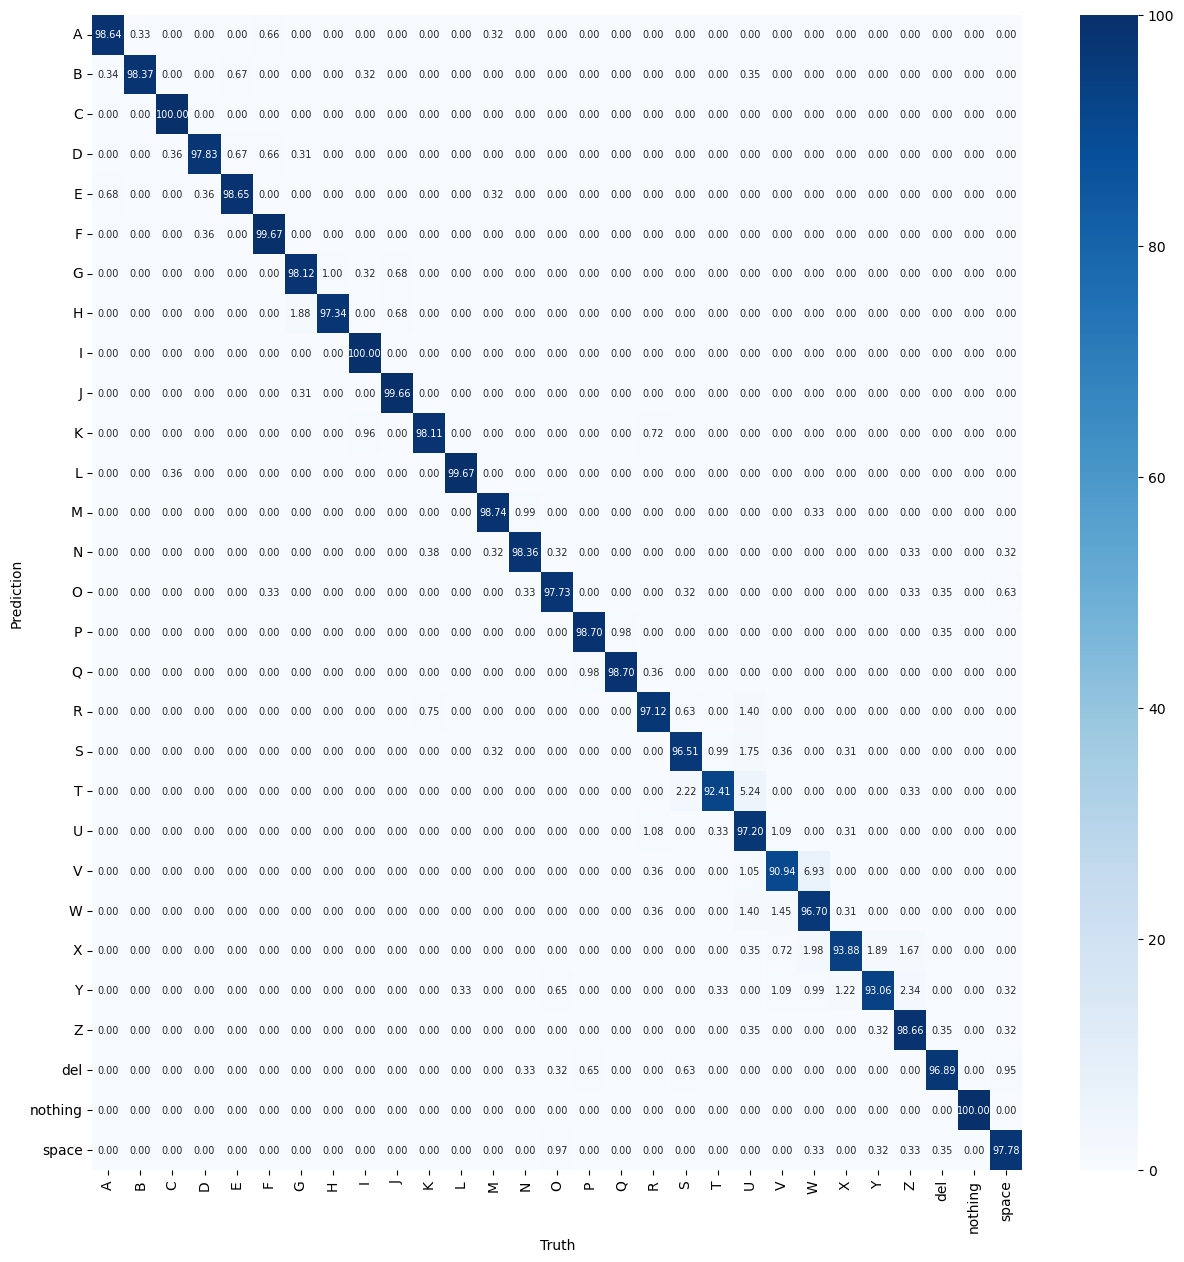

In [19]:
plt.figure(figsize=[15,15])
df = pd.DataFrame(100 * confusion_matrix / class_count)
ax = sn.heatmap(df, vmin=0, vmax=100, cmap='Blues', annot=True, fmt='.2f', annot_kws={"size":7}, 
               xticklabels = classes, yticklabels = classes)
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
plt.show()

## Confusion matrix heatmap without the diogonal elements

Setting the diagonal elements to zero makes it easier to see where most of the errors are happening.

In [20]:
# making a copy of the complete confusion matrix
confusion_matrix_ND = confusion_matrix.copy()

# putting all the diagonal elements to zero
for i in range(29):
    confusion_matrix_ND[i,i] = 0

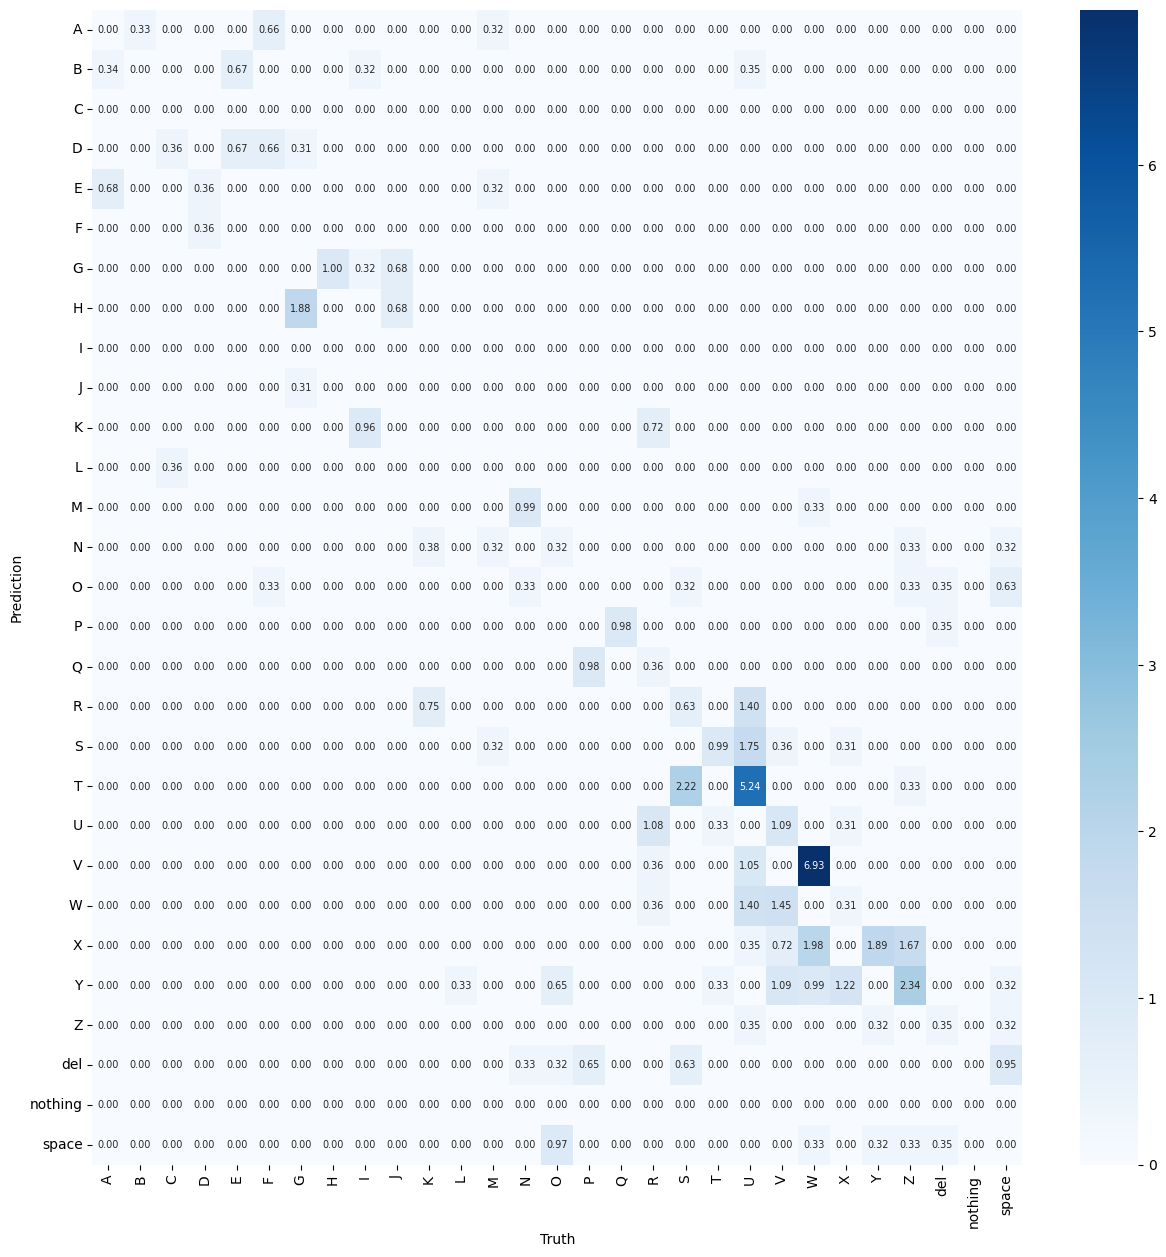

In [21]:
plt.figure(figsize=[15,15])
df = pd.DataFrame(100 * confusion_matrix_ND / class_count)
ax = sn.heatmap(df, cmap='Blues', annot=True, fmt='.2f', annot_kws={"size":7}, 
               xticklabels = classes, yticklabels = classes)
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
plt.show()

# Saving the model  

In [23]:
torch.save(model.state_dict(), "/home/kamiar/proj/model_parm")